# Float conversion

I came up with the following question $(float64)x < (float64)y \Longrightarrow (float32) x < (float32)y$? What is the probability this holds?

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

## Probability (float64)x == (float32)x

Let's evaluate how many time we draw a random double number equal to its float conversion.

In [3]:
import numpy
rnd = numpy.random.random(100000000)
rnd.shape, rnd.dtype

((100000000,), dtype('float64'))

In [4]:
rnd32 = rnd.astype(numpy.float32).astype(numpy.float64)
equal = (rnd == rnd32).sum()
equal

2

It is very low. Let's check the reverse is true.

In [5]:
rnd32b = rnd32.astype(numpy.float64).astype(numpy.float32)
equal = (rnd32b == rnd32).sum()
equal

100000000

Let's study the distribution of the difference.

In [6]:
delta = rnd - rnd32
numpy.min(delta), numpy.max(delta)

(-2.9802321610539195e-08, 2.9802320611338473e-08)

In [7]:
numpy.min(rnd), numpy.max(rnd)

(5.400330183036317e-10, 0.9999999976946683)

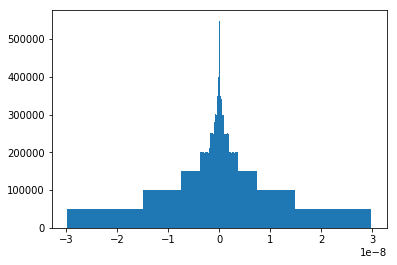

In [8]:
import matplotlib.pyplot as plt
plt.hist(delta, bins=1000);

We finally check that double operations between float numpers remain floats.

In [9]:
import random
for i in range(0,100000):
    i,j = random.randint(0, len(rnd32)-1), random.randint(0, len(rnd32)-1)
    d32 = numpy.float64(rnd32[i] * rnd32[j])
    d64 = numpy.float64(rnd32[i]) * numpy.float64(rnd32[j])
    if d32 != d64:
        raise Exception("Issue with somme={0} = {1} + {2}".format(rnd32[i] + rnd32[j], rnd32[i], rnd32[j]))

## Interval length distribution

Let's imagine now we want to define an intervalle in which a double is converted to the same float. Let's find out about it length.

In [10]:
def find_interval(x):
    dx = numpy.abs(x - numpy.float32(x))  # usually not zero
    dx /= 100
    f = numpy.float32(x)
    x1 = x
    while numpy.float32(x1) == f:
        x1 -= dx
    x2 = x
    while numpy.float32(x2) == f:
        x2 += dx
    return x1 + dx, x2 - dx

length = numpy.zeros((2000,))
for i in range(length.shape[0]):
    x = rnd[i]
    x1, x2 = find_interval(x)
    length[i] = x2-x1   

min(length), max(length)

(7.245554200022153e-12, 5.9604641222676946e-08)

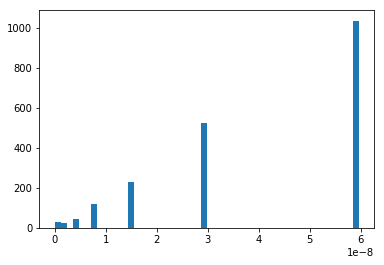

In [11]:
plt.hist(length, bins=50);

So we can approximate this interval by something like this:

In [12]:
ql = numpy.sort(length)[int(length.shape[0] * 0.8)]
ql

5.953141313241872e-08

## An answer to the initial question

Let's estimate $\mathbb{P}\left(x_{64} < y_{64} \Longrightarrow x_{32} < y_{32} \; | \; |x-y| \leqslant d\right)$ ?

In [13]:
import pandas

def inf_strict(x, y):
    f1 = x < y
    f2 = numpy.float32(x) < numpy.float32(y)
    return f1, f2

def count_events(fct):
    rows = []
    for di in range(1, 1001):
        d = di * ql / 100
        total = 0
        ok = 0
        rnd = numpy.random.random((2000*3,))
        for i in range(0, rnd.shape[0], 3):
            s = -1 if rnd[i+2] < 0.5 else 1
            x, y = rnd[i], rnd[i] + rnd[i+1]*d*s
            f1, f2 = fct(x, y)
            if f1: 
                total += 1
                if f2:
                    ok += 1
        if (di+10) % 100 == 0:
            print(di, d, ":", ok, total)
        rows.append(dict(d=d, ratio=ok*1./total, total=total))

    return pandas.DataFrame(rows)

df = count_events(inf_strict)
df.head()

90 5.357827181917685e-08 : 638 991
190 1.1310968495159557e-07 : 812 1018
290 1.726410980840143e-07 : 889 1011
390 2.32172511216433e-07 : 918 986
490 2.9170392434885173e-07 : 901 981
590 3.5123533748127045e-07 : 936 986
690 4.1076675061368917e-07 : 964 1004
790 4.702981637461079e-07 : 982 1021
890 5.298295768785266e-07 : 964 998
990 5.893609900109453e-07 : 946 975


,d,ratio,total
0,5.953141e-10,0.019447,977
1,1.190628e-09,0.041879,979
2,1.785942e-09,0.065590,991
3,2.381257e-09,0.063000,1000
4,2.976571e-09,0.072217,997


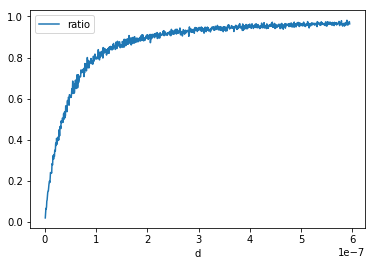

In [14]:
df.plot(x="d", y="ratio")

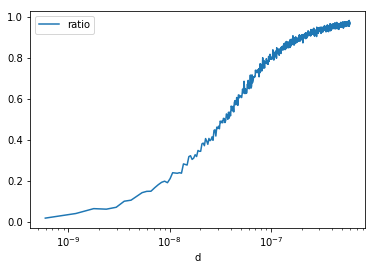

In [15]:
df.plot(x="d", y="ratio", logx=True)

## An answer to a similar question: what about not strict comparison?

Let's estimate $\mathbb{P}\left(x_{64} \leqslant y_{64} \Longrightarrow x_{32} \leqslant y_{32} \; | \; |x-y| \leqslant d\right)$ ?

In [16]:
def inf_equal(x, y):
    f1 = x <= y
    f2 = numpy.float32(x) <= numpy.float32(y)
    return f1, f2

df2 = count_events(inf_equal)
df2.head()

90 5.357827181917685e-08 : 966 966
190 1.1310968495159557e-07 : 1015 1015
290 1.726410980840143e-07 : 1004 1004
390 2.32172511216433e-07 : 991 991
490 2.9170392434885173e-07 : 1015 1015
590 3.5123533748127045e-07 : 975 975
690 4.1076675061368917e-07 : 969 969
790 4.702981637461079e-07 : 962 962
890 5.298295768785266e-07 : 1032 1032
990 5.893609900109453e-07 : 1000 1000


,d,ratio,total
0,5.953141e-10,1.0,996
1,1.190628e-09,1.0,969
2,1.785942e-09,1.0,1004
3,2.381257e-09,1.0,979
4,2.976571e-09,1.0,1041


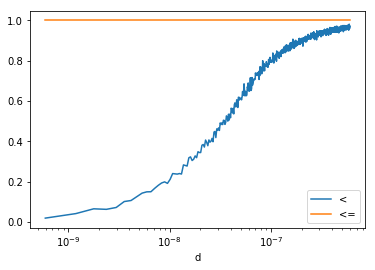

In [17]:
ax = df.plot(x="d", y="ratio", logx=True, label="<")
df2.plot(x="d", y="ratio", logx=True, label="<=", ax=ax)

In [18]:
def sup_strict(x, y):
    f1 = x > y
    f2 = numpy.float32(x) > numpy.float32(y)
    return f1, f2

df3 = count_events(sup_strict)
df3.head()

90 5.357827181917685e-08 : 652 1008
190 1.1310968495159557e-07 : 799 964
290 1.726410980840143e-07 : 871 994
390 2.32172511216433e-07 : 881 969
490 2.9170392434885173e-07 : 961 1014
590 3.5123533748127045e-07 : 906 958
690 4.1076675061368917e-07 : 930 973
790 4.702981637461079e-07 : 1004 1036
890 5.298295768785266e-07 : 962 1012
990 5.893609900109453e-07 : 972 1016


,d,ratio,total
0,5.953141e-10,0.024291,988
1,1.190628e-09,0.044838,959
2,1.785942e-09,0.057769,1004
3,2.381257e-09,0.087000,1000
4,2.976571e-09,0.091769,1057


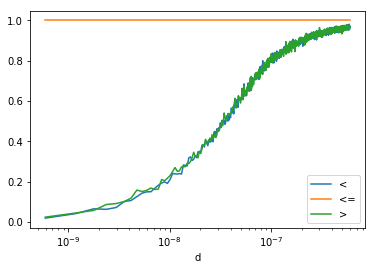

In [19]:
ax = df.plot(x="d", y="ratio", logx=True, label="<")
df2.plot(x="d", y="ratio", logx=True, label="<=", ax=ax)
df3.plot(x="d", y="ratio", logx=True, label=">", ax=ax)

In [20]:
def sup_equal(x, y):
    f1 = x >= y
    f2 = numpy.float32(x) >= numpy.float32(y)
    return f1, f2

df4 = count_events(sup_equal)
df4.head()

90 5.357827181917685e-08 : 964 964
190 1.1310968495159557e-07 : 1010 1010
290 1.726410980840143e-07 : 1009 1009
390 2.32172511216433e-07 : 990 990
490 2.9170392434885173e-07 : 967 967
590 3.5123533748127045e-07 : 1019 1019
690 4.1076675061368917e-07 : 1013 1013
790 4.702981637461079e-07 : 1020 1020
890 5.298295768785266e-07 : 996 996
990 5.893609900109453e-07 : 964 964


,d,ratio,total
0,5.953141e-10,1.0,1031
1,1.190628e-09,1.0,1013
2,1.785942e-09,1.0,975
3,2.381257e-09,1.0,998
4,2.976571e-09,1.0,1022


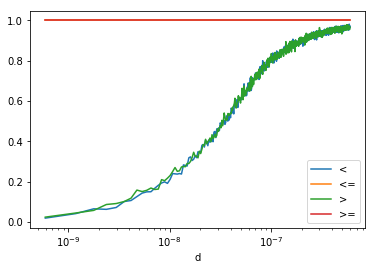

In [21]:
ax = df.plot(x="d", y="ratio", logx=True, label="<")
df2.plot(x="d", y="ratio", logx=True, label="<=", ax=ax)
df3.plot(x="d", y="ratio", logx=True, label=">", ax=ax)
df4.plot(x="d", y="ratio", logx=True, label=">=", ax=ax)

In [22]:
def inf_strict_neg(x, y):
    f1 = (-x) >= (-y)
    f2 = (-numpy.float32(x)) >= (-numpy.float32(y))
    return f1, f2

dfn = count_events(inf_strict_neg)
dfn.head()

90 5.357827181917685e-08 : 999 999
190 1.1310968495159557e-07 : 1019 1019
290 1.726410980840143e-07 : 1013 1013
390 2.32172511216433e-07 : 994 994
490 2.9170392434885173e-07 : 1012 1012
590 3.5123533748127045e-07 : 984 984
690 4.1076675061368917e-07 : 1024 1024
790 4.702981637461079e-07 : 982 982
890 5.298295768785266e-07 : 966 966
990 5.893609900109453e-07 : 1001 1001


,d,ratio,total
0,5.953141e-10,1.0,976
1,1.190628e-09,1.0,983
2,1.785942e-09,1.0,1024
3,2.381257e-09,1.0,966
4,2.976571e-09,1.0,1016


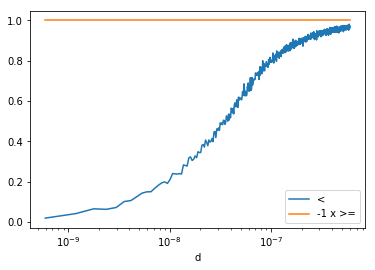

In [23]:
ax = df.plot(x="d", y="ratio", logx=True, label="<")
dfn.plot(x="d", y="ratio", logx=True, label="-1 x >=", ax=ax)

## Conclusion

The result is expected. As soon as two float are rounded to the same value, the strict inequality no longer holds. However, if you need to write a code which has to handle double and float (in a template for example), you should use not strict inequalities. It is easier to compare the results but you should read some article like [Is < faster than <=?](https://stackoverflow.com/questions/12135518/is-faster-than). According to [Processing costs of non-strict
versus strict comparison](http://www.crcummins.com/CRCProcessing.pdf), ``<`` is 5-10% faster than ``<=``.